## Question 9.1

Defina  a estrutura de uma rede perceptron de múltiplas camadas para aproximar a seguinte função:

$f(x_1,x_2) = (\frac{cos(2\pi x_1)}{1-(4x_1)^2}sin(\pi x_1)/ \pi x_1)(\frac{cos(2\pi x_2)}{1-(4x_2)^2}sin(\pi x_2)/ \pi x_2)$ com $-4\pi \leq x_1, x_2 \leq 4\pi$

### Importing libraries

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

### Generating Data

In [3]:
def f(x1,x2):
    first_part = np.cos(2*np.pi*x1)*np.sin(np.pi*x1)/((1 - (4*x1)**2)*np.pi*x1)
    second_part = np.cos(2*np.pi*x2)*np.sin(np.pi*x2)/((1 - (4*x2)**2)*np.pi*x2)
    return first_part*second_part
    # return (np.cos(2*np.pi*x1)*np.sin(np.pi*x1)/((1 - (4*x1)**2)*()))(np.cos(2*np.pi*x2)*np.sin(np.pi*x2)/((1 - (4*x2)**2)*(np.pi*x2)))

In [43]:
qtd_points = 150

x1, x2 = np.meshgrid(np.linspace(-4*np.pi, 4*np.pi, qtd_points), np.linspace(-4*np.pi, 4*np.pi, qtd_points))
y = f(x1,x2)

### Plotting Data

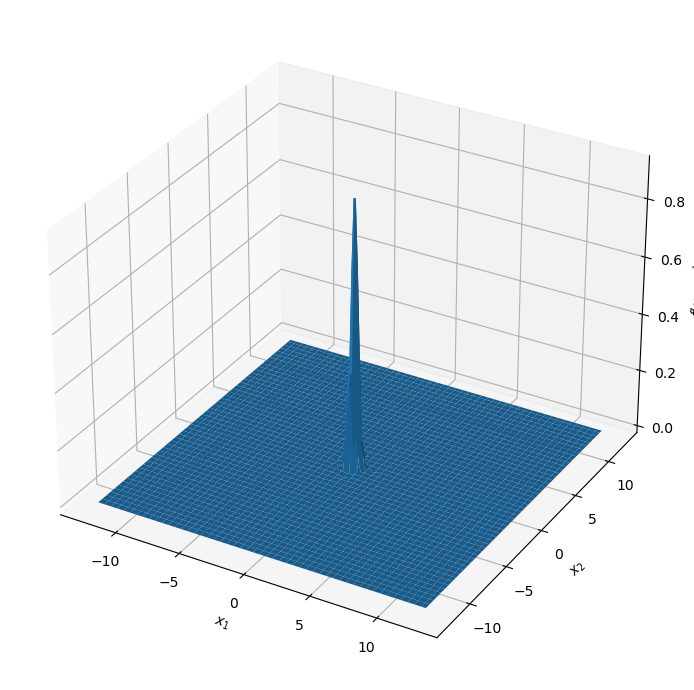

In [44]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(projection='3d'))

ax.plot_surface(x1, x2, y)

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='$f(x_1, x_2)$'
)

plt.tight_layout()
plt.show()

### Train Test Split

In [45]:
# split training and test
x_train, x_test, y_train, y_test = train_test_split(
    np.vstack([x1.flatten(), x2.flatten()]).T, 
    y.flatten(), 
    test_size=0.2, 
    random_state=42
)

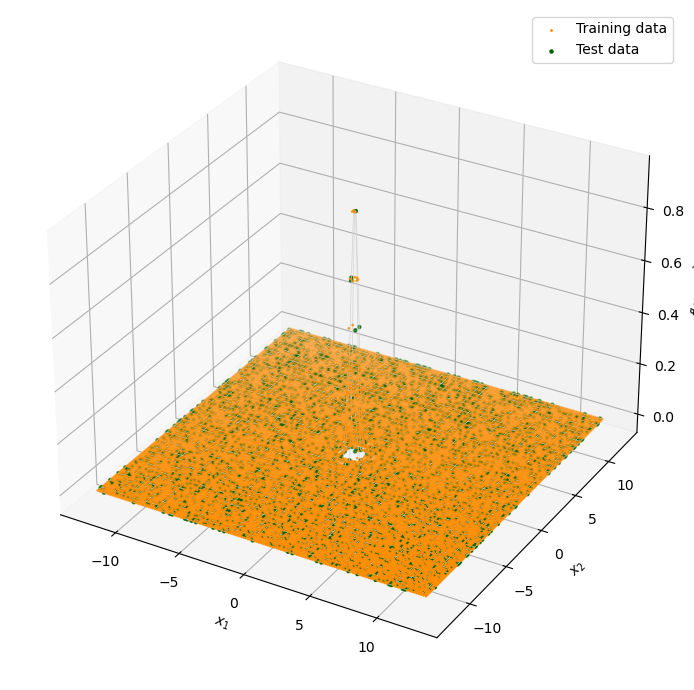

In [46]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(projection='3d'))

ax.plot_wireframe(x1, x2, y, linewidths=0.5, color='lightgrey')
ax.scatter(x_train[:,0], x_train[:,1], y_train, s=1, color='darkorange', label='Training data')
ax.scatter(x_test[:,0], x_test[:,1], y_test, s=5, color='darkgreen', label='Test data')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='$f(x_1, x_2)$'
)

plt.legend()
plt.tight_layout()
plt.show()

### Training

In [54]:
# transform to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [55]:
def get_model_9_1(device):
    # return a model mlp to approximate f(x1,x2)
    model = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(2, 64)),
        ('relu1', nn.ReLU()),
        ('fc2', nn.Linear(64, 32)),
        ('relu2', nn.ReLU()),
        ('fc3', nn.Linear(32, 16)),
        ('relu3', nn.ReLU()),
        ('fc4', nn.Linear(16, 8)),
        ('relu4', nn.ReLU()),
        ('fc5', nn.Linear(8, 4)),
        ('relu5', nn.ReLU()),
        ('fc6', nn.Linear(4, 1))
        
    ])).to(device)

    return model

In [56]:
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070'

In [57]:
model_9_1 = get_model_9_1(device)
# check the number of parameters
sum(p.numel() for p in model_9_1.parameters())

2977

In [58]:
optimizer = torch.optim.RMSprop(model_9_1.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [59]:
train_dataloader = DataLoader(
    list(zip(x_train, y_train)),
    batch_size=64,
    shuffle=True
)

test_dataloader = DataLoader(
    list(zip(x_test, y_test)),
    batch_size=64,
    shuffle=False
)

In [60]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=100, device=device):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        model.eval()
        with torch.no_grad():
            for x, y in test_dataloader:
                x = x.to(device)
                y = y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
        test_loss.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}')
    return train_loss, test_loss

In [61]:
train_loss, test_loss = train(model_9_1, train_dataloader, test_dataloader, criterion, optimizer, epochs=20, device=device)

/home/morsinaldo/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/morsinaldo/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/morsinaldo/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadca

Epoch 1/20, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 11/20, Train Loss: 0.0000, Test Loss: 0.0000


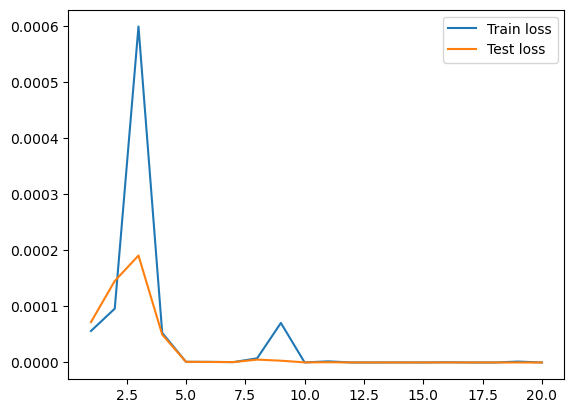

In [62]:
 # plot the loss
plt.plot(np.arange(1,21), train_loss, label='Train loss')
plt.plot(np.arange(1,21), test_loss, label='Test loss')
plt.legend()
plt.show()

### Evaluating

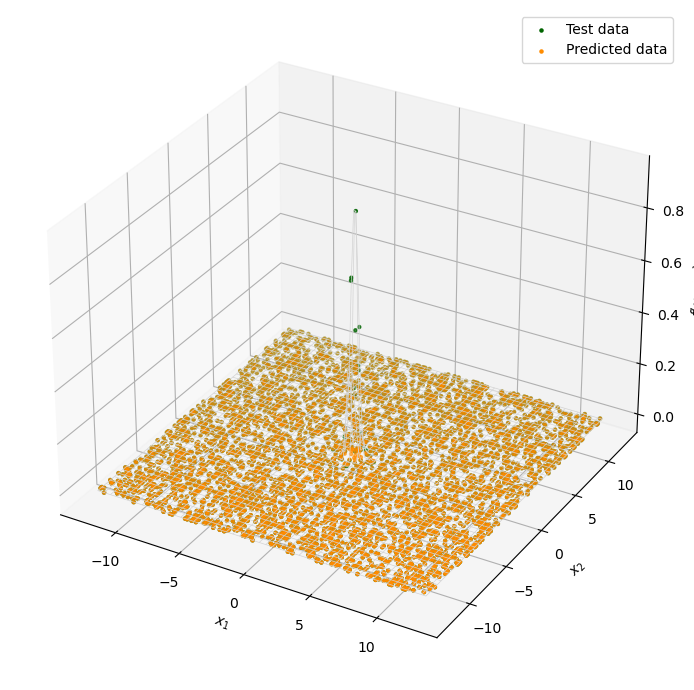

In [69]:
y_pred = model_9_1(x_test.to(device)).cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(projection='3d'))

ax.plot_wireframe(x1, x2, y, linewidths=0.5, color='lightgrey')
ax.scatter(x_test[:,0], x_test[:,1], y_test, s=5, color='darkgreen', label='Test data')
ax.scatter(x_test[:,0], x_test[:,1], y_pred, s=5, color='darkorange', label='Predicted data')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='$f(x_1, x_2)$'
)

plt.legend()
plt.tight_layout()
plt.show()


In [64]:
mse = ((y_test - y_pred.flatten())**2).mean()
print(f'Mean Squared Error: {mse:.4f}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.4f}')
mae = np.abs(y_test - y_pred.flatten()).mean()
print(f'Mean Absolute Error: {mae:.4f}')

Mean Squared Error: 0.0006
Root Mean Squared Error: 0.0239
Mean Absolute Error: 0.0011
